In [1]:
import numpy as np
import pandas as pd

This is a template for your final project. 

In [2]:
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


In [3]:
full_dataset.isnull().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      5
language                   439
director                    24
writer                     808
production_company        2744
actors                      30
description               1993
avg_vote                     0
votes                        0
budget                   43379
usa_gross_income         48306
worlwide_gross_income    41062
metascore                51386
reviews_from_users        4069
reviews_from_critics      8229
dtype: int64

In [4]:
full_dataset.dtypes

imdb_title_id             object
title                     object
original_title            object
year                       int64
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

In [5]:
full_dataset.shape

(60198, 22)

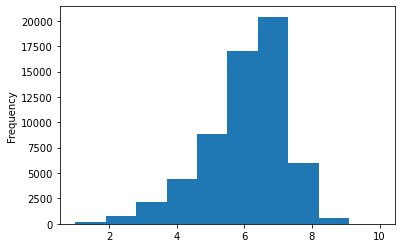

In [6]:
full_dataset.avg_vote.plot.hist()

In [7]:
full_dataset.votes.min(), full_dataset.votes.max(), full_dataset.votes.mean()

(100, 2159628, 10491.500564802818)

### Part 1.

Task formalization and Evaluation criteria

1.1 Select your target variable, explain your choice. Separate target variable from the feature matrix.

__I choose "avg_vote" as target. Becasue there is no missing value, audiences opinion is a good measurement. More importantly, all the money related columns have a lot of missing values. If we can't measure success by income, at least we can measure it by good will.__

In [8]:
target = full_dataset.avg_vote
features = full_dataset.drop(['avg_vote'], axis=1)

1.2 Explain which task are you going to solve (is it a regression, classification or something else)? 

__I'd use a regression to predict. There shuold be no absolute difference between 6.4 and 6.5. Whether successful should be a linear measurement.__

1.3 Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it. 

__I will use mean squared error__

In [9]:
from sklearn.metrics import mean_squared_error

### Part 2.

Explore and preprocess the data

2.1 Split data into train and test

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48158, 21), (12040, 21), (48158,), (12040,))

2.2 Explore you data: make plots, print tables. Make sure to write your observations.  Do not forget to fill-in missing values, define relevant columns transformatios. 


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MultiLabelBinarizer, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge

In [13]:
full_dataset.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

- __'imdb_title_id', 'title', 'original_title'__ are irrelevant.
- __'year'__, even we can find relationship between 'year' and target. It's not like we can go back to history and make a movie. 
- __'date_published'__, extract month from it, movie business can be seasonal. 
- __'director', 'writer', 'production_company', 'actors', 'description'__, I tried to find common words from these features, but the rows are very different from each other, so I drop them.
- __'genre', 'country', 'language'__, find the most frequently occured words from them, and encode.
- __'duration', 'votes', 'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore', 'reviews_from_users', 'reviews_from_critics'__, trim them and fill in the missing values with mean, and apply scaler.

In [14]:
# columns to remove

# director, writer, production_company, actors are vary, 
# hard to find any relationship with target, remove them for now
full_dataset.director.unique().shape, full_dataset.writer.unique().shape, \
full_dataset.production_company.unique().shape, full_dataset.actors.unique().shape

# remove imdb_title_id, title, original_title, description, they are irrelevant
# remove year, even it is useful, it's not like we can go back to history and make a movie.
col_remove = ['imdb_title_id', 'date_published', 'title', 'original_title', 'year', 'director', 'writer', \
              'production_company', 'actors', 'description']

In [15]:
# columns to convert

# date_published, transfer it to month
cat_col = ['genre', 'country', 'language']
num_col = ['duration', 'votes', 'budget', 'usa_gross_income', 'worlwide_gross_income', \
           'metascore', 'reviews_from_users', 'reviews_from_critics']

    
# genre, language, country transfer to array and use MultiLabelBinarizer
def get_predominant_values(col_name, threshold=300):
    vc = full_dataset[full_dataset[col_name].map(full_dataset[col_name].value_counts()) > threshold][col_name]
    
    vs = set()
    
    for vl in vc.unique():
        vs.update(set(map(str.strip, vl.split(","))))
        
    return list(vs)

predo_country = get_predominant_values('country', threshold=300)
# print(len(predo_country))

# similar as country, find most frequent language or language comninations, and apply MultiLabelBinarizer
predo_lang = get_predominant_values('language', threshold=300)
# print(predo_lang, len(predo_lang))

predo_genre = get_predominant_values('genre', threshold=0)
# print(predo_genre, len(predo_genre))


class NumPreprocessImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using mean value within group
    
    Parameters
    ----------    
    group_cols : str
        A column used to calculate the mean values
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, col_remove):
        self.col_remove = col_remove
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X = X.copy()

        X['month_published'] = pd.to_datetime(X.date_published).dt.month
        
        X = X.drop(self.col_remove, axis=1)
        
        for col in ['budget', 'usa_gross_income', 'worlwide_gross_income']:
            X[col] = X[col].str.replace(r'[^0-9]+', '', regex=True)
        
        return X.values

class CatPreprocessImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using mean value within group
    
    Parameters
    ----------    
    group_cols : str
        A column used to calculate the mean values
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X = X.fillna('')
        
        mb_country = MultiLabelBinarizer(classes=predo_country)
        mb_language = MultiLabelBinarizer(classes=predo_lang)
        mb_genre = MultiLabelBinarizer(classes=predo_genre)
        
        encoded_country = pd.DataFrame(\
                                      mb_country.fit_transform(X['country']\
                                                               .str.replace(r'\s', '', regex=True)\
                                                               .str.split(pat=',')), \
                                      columns=mb_country.classes_)
        
        encoded_language = pd.DataFrame(\
                                      mb_language.fit_transform(X['language']\
                                                               .str.replace(r'\s', '', regex=True)\
                                                               .str.split(pat=',')), \
                                      columns=mb_language.classes_)

        encoded_genre = pd.DataFrame(\
                                      mb_genre.fit_transform(X['genre']\
                                                               .str.replace(r'\s', '', regex=True)\
                                                               .str.split(pat=',')), \
                                      columns=mb_genre.classes_)

        result = pd.concat([encoded_country, encoded_language, encoded_genre], axis=1)
    
        return result.values


# trim budget, use_gross_incode, worldwide_gross_income

# fill with mean 
# budget, 43379; usa_gross_income, 48306; worlwide_gross_income, 41062; metascore, 51386; 
# reviews_from_users, 4069; reviews_from_critics, 8229 

num_pipe = make_pipeline(
    NumPreprocessImputer(col_remove),
    SimpleImputer(),
    StandardScaler(),
)

cat_pipe = make_pipeline(
    CatPreprocessImputer(),
)

num_col = ['duration', 'votes', 'budget', 'usa_gross_income', 'worlwide_gross_income', \
           'metascore', 'reviews_from_users', 'reviews_from_critics']

column_transformer = ColumnTransformer([
    ('num', num_pipe, num_col + col_remove),
    ('cat', cat_pipe, cat_col)
],remainder='passthrough')

In [16]:
x_trans = column_transformer.fit_transform(X_train)
x_trans.shape

(48158, 78)

### Part 3.

Train and compare the models

3.1. Select models, you are going to train, select hyperparameters that have to be tunes.

In [17]:
# GradientBoostingRegressor, RandomForestRegressor, SVC

model = Pipeline([
    ('column_transformer', column_transformer),
#     ('feat_selector', RFE(rfe_estimator, n_features_to_select=50)),
#     ('model', RandomForestRegressor())
    ('model', GradientBoostingRegressor())
])

# mmsc = MinMaxScaler(feature_range=(0,1))

# y_train_reshaped = np.array(y_train.values).reshape(-1, 1)

# y_train_sc = mmsc.fit_transform(y_train_reshaped)

# model.fit(X_train, y_train_sc)

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('column_transformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('numpreprocessimputer',
                                                                   NumPreprocessImputer(col_remove=['imdb_title_id',
                                                                                                    'date_published',
                                                                                                    'title',
                                                                                                    'original_title',
                                                                  

In [18]:
y_pred = model.predict(X_test)

In [19]:
mean_squared_error(y_pred, y_test)

0.8362497814462528

3.2 Use cross-validation to compare models and select best set of hyperparameters

In [20]:
param_grid = [
#     {
#         'model': [Ridge(), Lasso()],# list of possible models 
#         'model__alpha': [1e-2, 0.1, 1, 10]
#     },
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [500],#[int(x) for x in np.linspace(start = 100, stop = 150, num = 6)],
        'model__max_features': [1/3], #['auto', 'sqrt'],
        'model__criterion': ['mse'],
        'model__max_depth': [40], #[int(x) for x in np.linspace(10, 100, num = 10)],
#         'model__min_samples_split': #np.arange(2, 21, 1),
#         'model__min_samples_leaf': #np.arange(1, 21, 1),
    },
#     {
#         'model': [GradientBoostingRegressor()],
#         'model__criterion': ['mse'],
#         'model__loss': ['ls', 'lad', 'huber', 'quantile'],
#         'model__learning_rate': [0.75, 0.1],
#         'model__n_estimators': [500], #np.arange(100, 600, 100),
# #         'model__max_features': ['sqrt'],
# #         'model__max_depth': np.linspace(1, 32, 32, endpoint=True),
# #         'model__min_samples_split': #np.arange(2, 11, 1),
# #         'model__min_samples_leaf': #np.arange(1, 11, 1),
#     },
]

pipe_cv = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', \
                       verbose=2, n_jobs = -1)

In [21]:
pipe_cv.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), model__criterion=mse, model__max_depth=40, model__max_features=0.3333333333333333, model__n_estimators=500 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), model__criterion=mse, model__max_depth=40, model__max_features=0.3333333333333333, model__n_estimators=500, total=  54.1s
[CV] model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   54.1s remaining:    0.0s


[CV]  model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), model__criterion=mse, model__max_depth=40, model__max_features=0.3333333333333333, model__n_estimators=500, total=  54.4s
[CV] model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('column_transformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('numpreprocessimputer',
                                                                                          NumPreprocessImputer(col_remove=['imdb_title_id',
                                                                                                              

In [22]:
# print best estimator and its score on CV
print(pipe_cv.best_score_)
# print(pipe_cv.best_estimator_)
print(pipe_cv.best_params_)

-0.7330776825688757
{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features=0.3333333333333333,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False), 'model__criterion': 'mse', 'model__max_depth': 40, 'model__max_features': 0.3333333333333333, 'model__n_estimators': 500}


In [23]:
y_pred_final = pipe_cv.best_estimator_.predict(X_test)

In [24]:
mean_squared_error(y_pred_final, y_test)

0.7377023799628373

3.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?

__RandomForestRegressor, with parameter max_depth=40, max_features=1/3, n_estimators=500 performed best. It also performed good on the test dataset.__

__This model uses Random Forest Regression which is a supervised learning algorithm that uses ensemble learning, which is a composition of Decision trees. It operates by constructing several decision trees during training time and outputting the mean of the classes as the prediction of all the trees. It has excellent predictive powers, if you feed it more quality data, it can perform much beter. And it is easy to use. For the given dataset, it will show you how the audiences likely to react, with limited and uncompleted data.__